## Description

This notebook creates the federated dataset step-by-step for central and federated learning. The steps are:
- Rename CESNET-QUIC22 files
- Filter them for target applications and organizations
- Columnize the PPI and histogram fields
- Calculate and add additional features such as SUBPSTATS and SUBFLOWSTATS
- Preprocess then create the central dataset and client datasets
- Create the chunks for federated learning.

## Import

In [2]:
import sys, os, json, logging

import pandas as pd
import numpy as np
import ipaddress
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from configuration import Configuration
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from os.path import join as path
from warnings import simplefilter
from functools import partial, lru_cache
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from tqdm import tqdm

# Configuration
c = Configuration()

# logging
logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s [%(levelname)s] %(message)s",
)
logger = logging.getLogger(__name__)

## Rename dataset files

This code will rename the daily files to be able to process them more efficently.

New flow file for each day: **flows.csv.gz**

New stats file for each day: **stats.json**

In [2]:
def rename_files():
    for week in c.weeks:
        for day in c.days:
            for filename in os.listdir(path(c.path_dataset, "0-cesnet-quic22", week, day)):
                if ".csv" in filename:
                    os.rename(path(c.path_dataset, "0-cesnet-quic22", week, day, filename), path(c.path_dataset, "0-cesnet-quic22", week, day, "flows.csv.gz"))
                elif ".json" in filename:
                    os.rename(path(c.path_dataset, "0-cesnet-quic22", week, day, filename), path(c.path_dataset, "0-cesnet-quic22", week, day, "stats.json"))

In [3]:
rename_files()

## 1 - Filter
Filter the dataset for target applications and organizations. If you don't have access to the prefixes-orgs.csv, then this code will randomly determine the organizations.

In [12]:
def _find_best_network(ip, networks):
    ip_obj = ipaddress.ip_address(ip)
    best_match = None
    
    for network in networks:
        if ip_obj in network:
            if best_match is None or network.prefixlen > best_match.prefixlen:
                best_match = network

    return networks[best_match] if best_match else -1

def filter_ds(week, day, index):
    os.makedirs(path(c.path_dataset, "1-filtered"), exist_ok=True)
    
    PATH_DS = path(c.path_dataset, "0-cesnet-quic22", week, day, "flows.csv.gz")
    PATH_DS_OUTPUT = path(c.path_dataset, "1-filtered", f"day-{index}.parquet")
    
    ## Load data
    logger.info(f"Loading data for week {week} and day {day}")
    
    df = pd.read_csv( PATH_DS, compression="gzip", dtype={"APP":"category", "CATEGORY":"category"})
    
    df_len = len(df)
    
    ## Filter app
    logger.info(f" Filtering target applications")
    df = df[df["APP"].isin(c.classes)]
    
    logger.info(f" Filtered {((df_len-len(df))/df_len)*100.0}% of dataset.")
    
    ## Remove Unknown Orgs
    # If prefixes-orgs.csv doesn't exists or is faulty use random numbering instead.
    # Please contact the authors for the prefix mapping.
    try:
        logger.info(f" Determining organizations")
        prefixes = pd.read_csv("prefixes-orgs.csv")
        prefixes["Prefix"] = prefixes["Prefix"].map(lambda x: ipaddress.ip_network(x))
        prefixes_dict = prefixes.set_index("Prefix")["Organization ID"].to_dict()

        find_best_network_fn = lru_cache(maxsize=100000)(partial(_find_best_network, networks=prefixes_dict))
        df[c.org] = df["SRC_IP"].map(find_best_network_fn)
    except:
        df[c.org] = np.random.randint(1, 15+1, size=len(df))
        df[c.org] = df[c.org].apply(lambda x: -1 if x == 15 else x)
    
    df_preorg_len = len(df)
    logger.info(f" Removing unknown organizations")
    df = df[df[c.org] != -1]
    logger.info(f" Removed {((df_preorg_len-len(df))/df_preorg_len)*100.0}% of dataset.")
    
    ## Save data
    logger.info(f" Finished... saving...")
    df.to_parquet(PATH_DS_OUTPUT)
    
    df_filtered_len = len(df)
    
    logger.info(f"Filtering: {df_len - df_filtered_len} rows removed. Reduced dataset by {(df_len - df_filtered_len) / df_len * 100:.2f}%")

In [13]:
index = 1
for week in c.weeks:
    for day in c.days:
        filter_ds(week, day, index)
        index += 1

2025-06-05 10:55:18,307 [INFO] Loading data for week W-2022-44 and day 1_Mon
2025-06-05 10:55:46,037 [INFO]  Filtering target applications
2025-06-05 10:55:46,590 [INFO]  Filtered 72.34243332701428% of dataset.
2025-06-05 10:55:46,591 [INFO]  Determining organizations
2025-06-05 10:55:47,234 [INFO]  Removing unknown organizations
2025-06-05 10:55:47,404 [INFO]  Removed 64.91277021418989% of dataset.
2025-06-05 10:55:47,405 [INFO]  Finished... saving...
2025-06-05 10:55:48,179 [INFO] Filtering: 3229414 rows removed. Reduced dataset by 90.30%
2025-06-05 10:55:48,251 [INFO] Loading data for week W-2022-44 and day 2_Tue
2025-06-05 10:56:14,292 [INFO]  Filtering target applications
2025-06-05 10:56:14,802 [INFO]  Filtered 68.9664904288516% of dataset.
2025-06-05 10:56:14,802 [INFO]  Determining organizations
2025-06-05 10:56:15,454 [INFO]  Removing unknown organizations
2025-06-05 10:56:15,657 [INFO]  Removed 61.48265078615255% of dataset.
2025-06-05 10:56:15,658 [INFO]  Finished... saving.

## 2 - Eval
Eval the list fields into multiple columns and keep target applications

In [18]:
def eval_ds(index):
    os.makedirs(path(c.path_dataset, "2-eval"), exist_ok=True)
    
    PATH_DS_OUTPUT = path(c.path_dataset, "2-eval", f"day-{index}.parquet")
    
    ## Load data
    logger.info(f"Start evaling day-{index}.parquet...")
    df = c.load_data("1-filtered", index)

    # Takes a lot of time
    logger.info(" Apply eval to PPI...")
    df["PPI"] = df.apply(lambda x: eval(str(x["PPI"])), axis=1)

    # For each packet value we create a new column. If it has less than 30 packets, we are padding it with 0 values until it has.
    logger.info(" PPI to 3x30 columns...")
    for i in range(0,30):
        df[f"PIAT_{i+1}"] = df['PPI'].apply(lambda x: x[0][i] if len(x[0]) > i else 0)
    for i in range(0,30):
        df[f"DIR_{i+1}"]  = df['PPI'].apply(lambda x: x[1][i] if len(x[1]) > i else 0)
    for i in range(0,30):
        df[f"PS_{i+1}"]   = df['PPI'].apply(lambda x: x[2][i] if len(x[2]) > i else 0)
    
    df = df.drop(["PPI"], axis=1)

    # For each histogram value we create a new column. Each histogram has 8 values.
    logger.info(" Histogram to 4x8 columns...")
    for col in ["PHIST_SRC_SIZES","PHIST_DST_SIZES","PHIST_SRC_IPT","PHIST_DST_IPT"]:
        df[col] = df.apply(lambda x: eval(str(x[col])), axis=1)
        for i in range(0,8):
            df[f"{col}_{i+1}"] = df[col].apply(lambda x: x[i])
        
        df = df.drop([col], axis=1)
    
    df.to_parquet(PATH_DS_OUTPUT)

In [19]:
for index in range(15, 28+1):
    eval_ds(index)

2025-06-05 11:28:18,602 [INFO] Start evaling day-15.parquet...
2025-06-05 11:28:19,737 [INFO]  Apply eval to PPI...
2025-06-05 11:29:05,732 [INFO]  PPI to 3x30 columns...
2025-06-05 11:29:26,716 [INFO]  Histogram to 4x8 columns...
2025-06-05 11:30:16,762 [INFO] Start evaling day-16.parquet...
2025-06-05 11:30:17,831 [INFO]  Apply eval to PPI...
2025-06-05 11:31:02,177 [INFO]  PPI to 3x30 columns...
2025-06-05 11:31:21,647 [INFO]  Histogram to 4x8 columns...
2025-06-05 11:32:10,832 [INFO] Start evaling day-17.parquet...
2025-06-05 11:32:11,720 [INFO]  Apply eval to PPI...
2025-06-05 11:32:45,647 [INFO]  PPI to 3x30 columns...
2025-06-05 11:33:00,894 [INFO]  Histogram to 4x8 columns...
2025-06-05 11:33:39,425 [INFO] Start evaling day-18.parquet...
2025-06-05 11:33:40,029 [INFO]  Apply eval to PPI...
2025-06-05 11:34:01,330 [INFO]  PPI to 3x30 columns...
2025-06-05 11:34:10,954 [INFO]  Histogram to 4x8 columns...
2025-06-05 11:34:34,903 [INFO] Start evaling day-19.parquet...
2025-06-05 11

# 3 - Additional features
Calculate additional flow statistics and features

In [22]:
def features_ds(index):
    logger.info("features_ds(): index: {}".format(index))
    
    PATH_DS_OUTPUT = path(c.path_dataset, "3-features", f"day-{index}.parquet")
    
    df = c.load_data("2-eval", index)
    
    df_flows = pd.DataFrame()
    
    logger.info("features_ds(): create bidirectional flowstats and calc directed ps and piats")
    
    # We go through all possible packet counts. In this way we have fix number of columns and easily can calculate statistics on them.
    for packet_count in range(2,30+1):
        logger.info("features_ds():    packet_count: {}".format(packet_count))
        df_tmp = df[df["PPI_LEN"] == packet_count][c.pstats].copy()
        columns_piat = [f"PIAT_{i+1}" for i in range(1,packet_count)]
        columns_ps = [f"PS_{i+1}" for i in range(0,packet_count)]
        
        # SUBPSTATS
        for i in range(1,30+1):
            df_tmp[f"SRC_PS_{i}"] = 0
            df_tmp[f"SRC_PIAT_{i}"] = 0
            df_tmp[f"DST_PS_{i}"] = 0
            df_tmp[f"DST_PIAT_{i}"] = 0
        
        # BIDIRECTIONAL SUBFLOWSTATS

        df_tmp["bidirectional_duration_ms"] = df_tmp[columns_piat].sum(axis=1)
        df_tmp["bidirectional_packets"] = packet_count
        df_tmp["bidirectional_bytes"] = df_tmp[columns_ps].sum(axis=1)

        df_tmp["bidirectional_min_piat_ms"] = df_tmp[columns_piat].min(axis=1)
        df_tmp["bidirectional_max_piat_ms"] = df_tmp[columns_piat].max(axis=1)
        df_tmp["bidirectional_mean_piat_ms"] = df_tmp[columns_piat].mean(axis=1)
        
        if packet_count == 2:
            df_tmp["bidirectional_stddev_piat_ms"] = 0
        else:
            df_tmp["bidirectional_stddev_piat_ms"] = df_tmp[columns_piat].std(axis=1)

        df_tmp["bidirectional_min_ps"] = df_tmp[columns_ps].min(axis=1)
        df_tmp["bidirectional_max_ps"] = df_tmp[columns_ps].max(axis=1)
        df_tmp["bidirectional_mean_ps"] = df_tmp[columns_ps].mean(axis=1)
        df_tmp["bidirectional_stddev_ps"] = df_tmp[columns_ps].std(axis=1)
        
        # SUBPSTATS
        
        df_tmp["src_ps"] = None
        df_tmp["dst_ps"] = None
        df_tmp["src_piat"] = None
        df_tmp["dst_piat"] = None
        
        for index, row in df_tmp.iterrows():
            src_ps, src_piat = [], []
            dst_ps, dst_piat = [], []
            
            # PS
            for i in range(0, packet_count):
                if row[f"DIR_{i+1}"] == 1:
                    src_ps.append(row[f"PS_{i+1}"])
                    df_tmp.at[index, f"SRC_PS_{len(src_ps)}"] = row[f"PS_{i+1}"]
                else:
                    dst_ps.append(row[f"PS_{i+1}"])
                    df_tmp.at[index, f"DST_PS_{len(dst_ps)}"] = row[f"PS_{i+1}"]
            df_tmp.at[index, "src_ps"] = src_ps
            df_tmp.at[index, "dst_ps"] = dst_ps
            
            # PIAT
            piat_src_wait_sum = 0
            piat_dst_wait_sum = 0
            
            # FIRST PIAT ALWAYS SRC AND 0
            df_tmp.at[index, f"SRC_PIAT_1"] = 0
            for i in range(1, packet_count):
                
                piat = row[f"PIAT_{i+1}"]
                # The DIR is SRC
                if row[f"DIR_{i+1}"] == 1:
                    piat_dst_wait_sum += piat
                    src_piat.append(piat_src_wait_sum + piat)
                    df_tmp.at[index, f"SRC_PIAT_{len(src_piat)+1}"] = piat_src_wait_sum + piat
                    piat_src_wait_sum = 0
                # The DIR is DST
                else:
                    piat_src_wait_sum += piat
                    dst_piat.append(piat_dst_wait_sum + piat)
                    df_tmp.at[index, f"DST_PIAT_{len(dst_piat)}"] = piat_dst_wait_sum + piat
                    piat_dst_wait_sum = 0
            
            
            df_tmp.at[index, "src_piat"] = src_piat
            df_tmp.at[index, "dst_piat"] = dst_piat
        
        # SRC SUBFLOWSTATS
        
        df_tmp["src2dst_packets"] = df_tmp["src_ps"].apply(lambda x: len(x))
        
        
        df_tmp["src2dst_bytes"] = df_tmp["src_ps"].apply(lambda x: np.sum(x) if len(x) > 0 else 0)
        
        df_tmp["src2dst_min_ps"] = df_tmp["src_ps"].apply(lambda x: np.min(x) if len(x) > 0 else 0)
        df_tmp["src2dst_max_ps"] = df_tmp["src_ps"].apply(lambda x: np.max(x) if len(x) > 0 else 0)
        df_tmp["src2dst_mean_ps"] = df_tmp["src_ps"].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
        df_tmp["src2dst_stddev_ps"] = df_tmp["src_ps"].apply(lambda x: np.std(x) if len(x) > 0 else 0)
        
        
        df_tmp["src2dst_duration_ms"] = df_tmp["src_piat"].apply(lambda x: np.sum(x) if len(x) > 0 else 0)

        df_tmp["src2dst_min_piat_ms"] = df_tmp["src_piat"].apply(lambda x: np.min(x) if len(x) > 0 else 0)
        df_tmp["src2dst_max_piat_ms"] = df_tmp["src_piat"].apply(lambda x: np.max(x) if len(x) > 0 else 0)
        df_tmp["src2dst_mean_piat_ms"] = df_tmp["src_piat"].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
        df_tmp["src2dst_stddev_piat_ms"] = df_tmp["src_piat"].apply(lambda x: np.std(x) if len(x) > 0 else 0)
        
        
        # DST SUBFLOWSTATS
        
        df_tmp["dst2src_packets"] = df_tmp["dst_ps"].apply(lambda x: len(x))
        
        
        df_tmp["dst2src_bytes"] = df_tmp["dst_ps"].apply(lambda x: np.sum(x) if len(x) > 0 else 0)
        
        df_tmp["dst2src_min_ps"] = df_tmp["dst_ps"].apply(lambda x: np.min(x) if len(x) > 0 else 0)
        df_tmp["dst2src_max_ps"] = df_tmp["dst_ps"].apply(lambda x: np.max(x) if len(x) > 0 else 0)
        df_tmp["dst2src_mean_ps"] = df_tmp["dst_ps"].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
        df_tmp["dst2src_stddev_ps"] = df_tmp["dst_ps"].apply(lambda x: np.std(x) if len(x) > 0 else 0)
        
        df_tmp["dst2src_duration_ms"] = df_tmp["dst_piat"].apply(lambda x: np.sum(x) if len(x) > 0 else 0)
        
        df_tmp["dst2src_min_piat_ms"] = df_tmp["dst_piat"].apply(lambda x: np.min(x) if len(x) > 0 else 0)
        df_tmp["dst2src_max_piat_ms"] = df_tmp["dst_piat"].apply(lambda x: np.max(x) if len(x) > 0 else 0)
        df_tmp["dst2src_mean_piat_ms"] = df_tmp["dst_piat"].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
        df_tmp["dst2src_stddev_piat_ms"] = df_tmp["dst_piat"].apply(lambda x: np.std(x) if len(x) > 0 else 0)
        
        del df_tmp["src_ps"]
        del df_tmp["dst_ps"]
        del df_tmp["src_piat"]
        del df_tmp["dst_piat"]
        
        df_flows = pd.concat([df_flows, df_tmp])
        
        del df_tmp
    
    logger.info("flow_ds(): concat")
    df_flows = pd.concat([df, df_flows[c.pflowstats+c._pstats_subdirs]], axis=1)
    
    logger.info("flow_ds(): to parquet")
    df_flows.to_parquet(PATH_DS_OUTPUT)
    
    logger.info("flow_ds(): Done!")

Add features

In [23]:
for index in range(15, 28+1):
    features_ds(index)

2025-06-05 12:03:24,205 [INFO] features_ds(): index: 15
2025-06-05 12:03:24,971 [INFO] features_ds(): create bidirectional flowstats and calc directed ps and piats
2025-06-05 12:03:24,971 [INFO] features_ds():    packet_count: 2
2025-06-05 12:03:25,033 [INFO] features_ds():    packet_count: 3
2025-06-05 12:03:25,109 [INFO] features_ds():    packet_count: 4
2025-06-05 12:03:25,482 [INFO] features_ds():    packet_count: 5
2025-06-05 12:03:25,542 [INFO] features_ds():    packet_count: 6
2025-06-05 12:03:25,667 [INFO] features_ds():    packet_count: 7
2025-06-05 12:03:26,693 [INFO] features_ds():    packet_count: 8
2025-06-05 12:03:26,998 [INFO] features_ds():    packet_count: 9
2025-06-05 12:03:30,742 [INFO] features_ds():    packet_count: 10
2025-06-05 12:03:41,064 [INFO] features_ds():    packet_count: 11
2025-06-05 12:03:49,788 [INFO] features_ds():    packet_count: 12
2025-06-05 12:03:54,743 [INFO] features_ds():    packet_count: 13
2025-06-05 12:04:00,043 [INFO] features_ds():    pac

# 4A - Preprocess and create DS

In [4]:
def dataset_ds(start_day=15, end_day=28):
    logger.info("Creating dataset")
    os.makedirs(path(c.path_dataset, "4-dataset"), exist_ok=True)
    os.makedirs(path(c.path_results, "class_labeling"), exist_ok=True)
    
    day_interval = range(start_day, end_day+1)
    starting_timestamp = pd.Timestamp('2022-11-14 00:00:00.000000')
    
    features = c.flowstats + c.pstats + c.pflowstats + c._pstats_subdirs
    columns = ["TIME_LAST", c.app, c.category, c.org] + features
    
    logger.info(" Loading data...")
    # Load all data
    df = pd.concat(
        # Load each day and concat then save
        [pd.read_parquet(path(c.path_dataset, "3-features", f"day-{i}.parquet"), columns=columns) for i in day_interval ], ignore_index=True, copy=False
    )
    
    # Datetime things
    logger.info(" Dropping rows with invalid TIME_LAST")
    len_df_1 = len(df) 
    df['TIME_LAST'] = pd.to_datetime(df['TIME_LAST'], format="%Y-%m-%dT%H:%M:%S.%f", errors='coerce')
    df = df.dropna(subset=['TIME_LAST'])
    len_df_2 = len(df) 
    logger.info(f" Dropped {len_df_1 - len_df_2} rows")
    
    logger.info(" Dropping flows which are exported before 2022-11-14 00:00:00.000000")
    df = df[df["TIME_LAST"] >= starting_timestamp]
    len_df_3 = len(df) 
    logger.info(f" Dropped {len_df_2 - len_df_3} rows")
    
    logger.info(" Sorting by TIME_LAST")
    df = df.sort_values(by="TIME_LAST")
    
    # Encode
    logger.info(" Label encoding")
    encoder = LabelEncoder()
    encoder = encoder.fit(df["APP"])
    classes = encoder.classes_
    
    class_to_integer = {cls: idx for idx, cls in enumerate(classes)}
    integer_to_class = {idx: cls for idx, cls in enumerate(classes)}
    class_to_category = dict(zip(df["APP"], df["CATEGORY"]))
    integer_to_category = {idx: class_to_category[cls] for idx, cls in enumerate(classes)}

    with open(path(c.path_results, "class_labeling", 'cls_to_int.json'), 'w') as class_to_int_file:
        json.dump(class_to_integer, class_to_int_file, indent=4)

    with open(path(c.path_results, "class_labeling", 'int_to_cls.json'), 'w') as int_to_class_file:
        json.dump(integer_to_class, int_to_class_file, indent=4)
        
    with open(path(c.path_results, "class_labeling", 'cls_to_cat.json'), 'w') as class_to_category_file:
        json.dump(class_to_category, class_to_category_file, indent=4)
        
    with open(path(c.path_results, "class_labeling", 'int_to_cat.json'), 'w') as int_to_category_file:
        json.dump(integer_to_category, int_to_category_file, indent=4)
    
    df["APP"] = encoder.transform(df["APP"])
    
    # Scale
    logger.info(" Standard scaling dataset")
    scaler = MinMaxScaler()
    
    df[features] = scaler.fit_transform(df[features])
    
    logger.info(" Saving dataset...")
    df.to_parquet(path(c.path_dataset, "4-dataset", f"dataset.parquet"))
    
    logger.info(" Saving dataset by ORG_ID ...")
    org = 1
    with tqdm(df[c.org].unique(), f"Organizations {org}/{len(df[c.org].unique())}") as orgs:
        for org_id in orgs:
            df[df[c.org] == org_id].to_parquet(path(c.path_dataset, "4-dataset", f"org-{org_id}.parquet"))

In [5]:
dataset_ds(15, 28)

2025-06-05 13:31:32,625 [INFO] Creating dataset
2025-06-05 13:31:32,628 [INFO]  Loading data...
2025-06-05 13:32:30,327 [INFO]  Dropping rows with invalid TIME_LAST
2025-06-05 13:32:46,023 [INFO]  Dropped 21 rows
2025-06-05 13:32:46,025 [INFO]  Dropping flows which are exported before 2022-11-14 00:00:00.000000
2025-06-05 13:32:54,308 [INFO]  Dropped 25593 rows
2025-06-05 13:32:54,311 [INFO]  Sorting by TIME_LAST
2025-06-05 13:33:03,105 [INFO]  Label encoding
2025-06-05 13:33:04,030 [INFO]  Standard scaling dataset
2025-06-05 13:35:35,021 [INFO]  Saving dataset...
2025-06-05 13:36:17,932 [INFO]  Saving dataset by ORG_ID ...
Organizations 1/14: 100%|██████████| 14/14 [02:29<00:00, 10.66s/it]


# 4B - Create chunks for central learning

In [9]:
os.makedirs(path(c.path_dataset, "4-dataset", "CL"), exist_ok=True)

df = pd.read_parquet(path(c.path_dataset, "4-dataset", f"dataset.parquet"), columns=c._flowstats + c._pstats + c._pflowstats + c._pstats_subdirs+c.appl)
df_len = len(df)

TEST_SAMPLE = int(df_len * 0.2)
VALIDATION_SAMPLE = int(df_len * 0.1)
TRAIN_SAMPLE = df_len - TEST_SAMPLE - VALIDATION_SAMPLE

TRAIN_BATCH_SAMPLE = 1000*c.batch_size_cl

## TEST CHUNK ##
df_test = df.sample(n=TEST_SAMPLE, random_state=c.random_state)
df_test.to_parquet(path(c.path_dataset, "4-dataset", "CL", f"test.parquet"))
df = df.drop(df_test.index)
del df_test

## VALIDATION CHUNK ##
df_val = df.sample(n=VALIDATION_SAMPLE, random_state=c.random_state)
df_val.to_parquet(path(c.path_dataset, "4-dataset", "CL", f"validation.parquet"))
df = df.drop(df_val.index)
del df_val

## TRAIN CHUNKS ##
train_chunk = 1
while len(df) != 0:
    df_train = df.sample(n=min(len(df), TRAIN_BATCH_SAMPLE), random_state=c.random_state)
    df_train.to_parquet(path(c.path_dataset, "4-dataset", "CL", f"train-{train_chunk}.parquet"))
    train_chunk += 1
    df = df.drop(df_train.index)
    del df_train

# 5A - Create Federated simulation DS-A

In [4]:
def real_world_A(time_window):
    scenario = "A"
    for org_id in range(1, 14+1):
        os.makedirs(path(c.path_dataset, "5-federated", f"realworld-{scenario}", f"client-{org_id}"), exist_ok=True)
        df_org = pd.read_parquet(path(c.path_dataset, "4-dataset", f"org-{org_id}.parquet"), columns=c.columns+["TIME_LAST"])

        # Sort by TIME_LAST timestamp
        df_org.loc[:, 'TIME_LAST'] = pd.to_datetime(df_org['TIME_LAST'], format="%Y-%m-%dT%H:%M:%S.%f", errors='coerce')
        df_org = df_org.dropna(subset=['TIME_LAST'])

        df_org = df_org.set_index('TIME_LAST')
        df_org = df_org.sort_values(by='TIME_LAST')
        
        chunk = 1
        # Sample dataset by a time window
        for timestamp, group in df_org.resample(time_window):
            # 70-20-10 train-test-validation split
            train, test = train_test_split(group, test_size=0.2, random_state=c.random_state)
            train, validation = train_test_split(train, test_size=0.125, random_state=c.random_state)
        
            train.to_parquet(path(c.path_dataset, "5-federated", f"realworld-{scenario}", f"client-{org_id}", f"train-chunk-{chunk}.parquet"))
            validation.to_parquet(path(c.path_dataset, "5-federated", f"realworld-{scenario}", f"client-{org_id}", f"validation-chunk-{chunk}.parquet"))
            test.to_parquet(path(c.path_dataset, "5-federated", f"realworld-{scenario}", f"client-{org_id}", f"test-chunk-{chunk}.parquet"))
            chunk += 1
            
real_world_A("3h")

Visualize train chunks

2025-06-05 14:19:51,089 [DEBUG] Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-06-05 14:19:51,090 [DEBUG] Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-06-05 14:19:57,998 [DEBUG] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-06-05 14:19:57,999 [DEBUG] findfont: score(FontEntry(fname='/Users/ejozric/Dipterv/dipterv_python_venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-06-05 14:19:57,999 [DEBUG] findfont: score(FontEntry(fname='/Users/ejozric/Dipterv/dipterv_python_venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-06-05 14:19:57,999 [DEBUG] findfont: scor

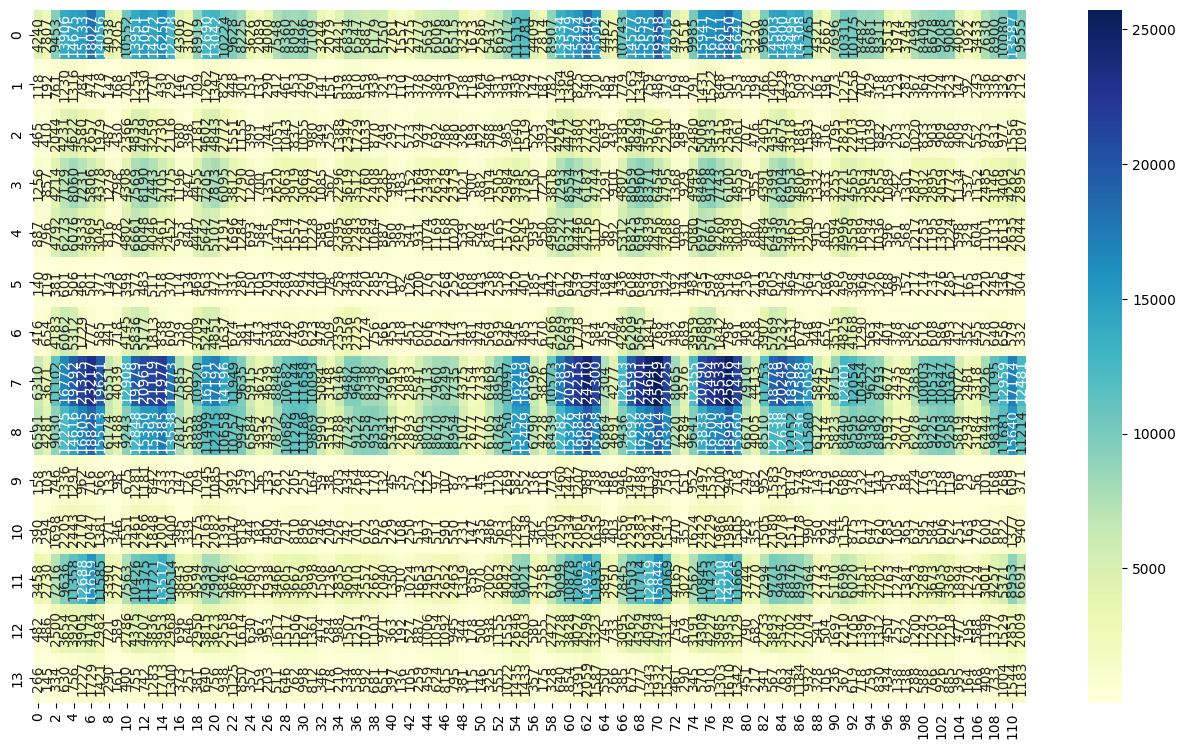

<Figure size 640x480 with 0 Axes>

In [5]:
plt.figure(figsize=(16, 9))

scenario = "realworld-A"

data = np.zeros((14, 112))
for run in range(1, 112+1):
    for org_id in range(1,14+1):
        try:
            df = pd.read_parquet(path(c.path_dataset, "5-federated", scenario, f"client-{org_id}", f"train-chunk-{run}.parquet"), columns=c.appl)
            data[org_id-1, run-1] = len(df)
        except:
            data[org_id-1, run-1] = 0

data = data.astype(int)
ax = sns.heatmap(
    data,
    cmap="YlGnBu",
    annot=True,
    fmt="d",
    cbar=True
)

for text in ax.texts:
    text.set_rotation(90)

plt.show()
plt.clf()

# 5B - Create Federated simulation DS-B with buffer mechanism

In [6]:
# Rolling Buffer
def real_world_B(time_window):
    scenario = "B"
    buffered_rows_train_max = c.batch_size_client * 100
    buffered_rows_test_max = int(buffered_rows_train_max / 0.7 * 0.2)
    buffered_rows_validation_max = int(buffered_rows_train_max / 0.7 * 0.1)
    for org_id in range(1, 14+1):
        os.makedirs(path(c.path_dataset, "5-federated", f"realworld-{scenario}", f"client-{org_id}"), exist_ok=True)
        df_org = pd.read_parquet(path(c.path_dataset, "4-dataset", f"org-{org_id}.parquet"), columns=c.columns+["TIME_LAST"])
    
        df_org.loc[:, 'TIME_LAST'] = pd.to_datetime(df_org['TIME_LAST'], format="%Y-%m-%dT%H:%M:%S.%f", errors='coerce')
        df_org = df_org.dropna(subset=['TIME_LAST'])

        df_org = df_org.set_index('TIME_LAST')
        df_org = df_org.sort_values(by='TIME_LAST')
        
        chunk = 1
        buffered_train = pd.DataFrame()
        buffered_test = pd.DataFrame()
        buffered_validation = pd.DataFrame()
        for timestamp, group in df_org.resample(time_window):
            
            train, test = train_test_split(group, test_size=0.2, random_state=c.random_state)    
            train, validation = train_test_split(train, test_size=0.125, random_state=c.random_state)
            
            buffered_train = pd.concat([buffered_train, train], ignore_index=True, copy=False)
            buffered_test = pd.concat([buffered_test, test], ignore_index=True, copy=False)
            buffered_validation = pd.concat([buffered_validation, validation], ignore_index=True, copy=False)
            
            total_train_rows = len(buffered_train)
            total_test_rows = len(buffered_test)
            total_validation_rows = len(buffered_validation)
            
            # There is not enough train rows buffered, export as test
            if total_train_rows < buffered_rows_train_max:
                buffered_rows = pd.concat([buffered_train, buffered_test, buffered_validation], ignore_index=True, copy=False)
                buffered_rows.to_parquet(path(c.path_dataset, "5-federated", f"realworld-{scenario}", f"client-{org_id}", f"test-chunk-{chunk}.parquet"))
            # There is much more rows than needed.
            else:
                rows_to_remove_from_train = total_train_rows - buffered_rows_train_max
                rows_to_remove_from_test = total_test_rows - buffered_rows_test_max
                rows_to_remove_from_validation = total_validation_rows - buffered_rows_validation_max
                
                buffered_train = buffered_train.iloc[rows_to_remove_from_train:]
                buffered_test = buffered_test.iloc[rows_to_remove_from_test:]
                buffered_validation = buffered_validation.iloc[rows_to_remove_from_validation:]
                
                buffered_train.to_parquet(path(c.path_dataset, "5-federated", f"realworld-{scenario}", f"client-{org_id}", f"train-chunk-{chunk}.parquet"))
                buffered_test.to_parquet(path(c.path_dataset, "5-federated", f"realworld-{scenario}", f"client-{org_id}", f"test-chunk-{chunk}.parquet"))
                buffered_validation.to_parquet(path(c.path_dataset, "5-federated", f"realworld-{scenario}", f"client-{org_id}", f"validation-chunk-{chunk}.parquet"))
                
            chunk += 1
            
            
real_world_B("3h")

Visualize train chunks

2025-06-05 14:31:41,249 [DEBUG] locator: <matplotlib.ticker.AutoLocator object at 0x12a08f170>


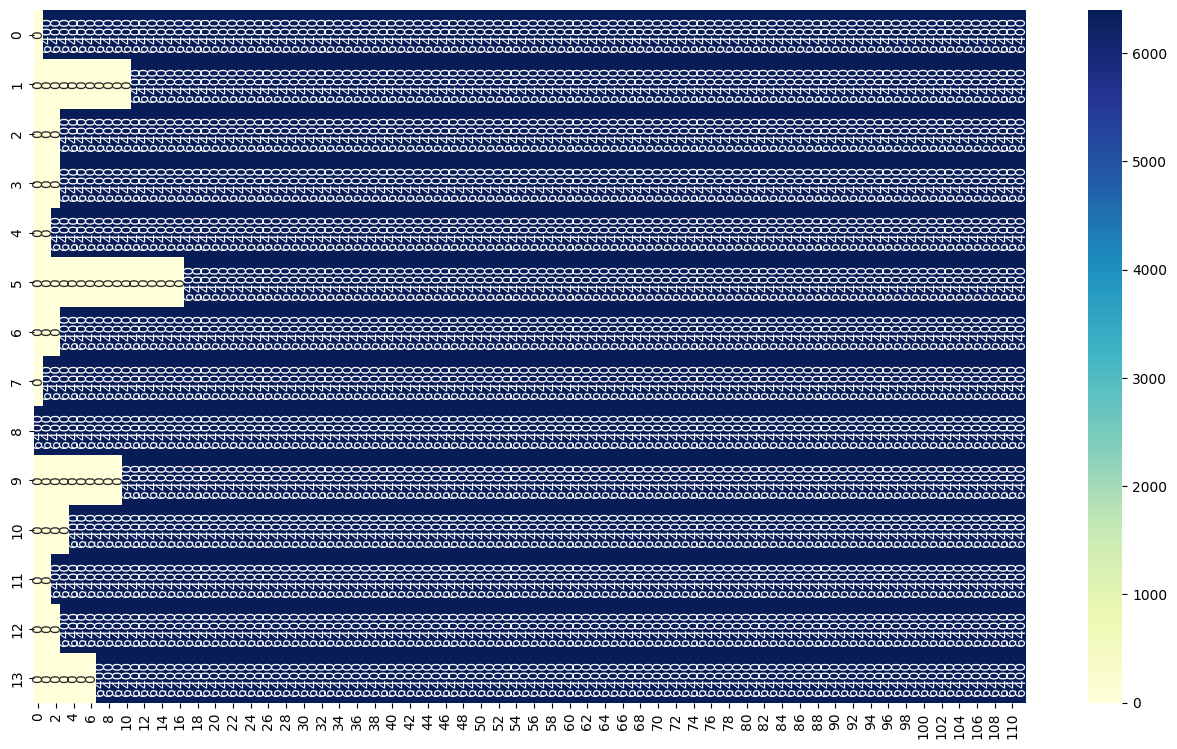

<Figure size 640x480 with 0 Axes>

In [8]:
plt.figure(figsize=(16, 9))

scenario = "realworld-B"

data = np.zeros((14, 112))
for run in range(1, 112+1):
    for org_id in range(1,14+1):
        try:
            df = pd.read_parquet(path(c.path_dataset, "5-federated", scenario, f"client-{org_id}", f"train-chunk-{run}.parquet"), columns=c.appl)
            data[org_id-1, run-1] = len(df)
        except:
            data[org_id-1, run-1] = 0

data = data.astype(int)
ax = sns.heatmap(
    data,
    cmap="YlGnBu",
    annot=True,
    fmt="d",
    cbar=True
)

for text in ax.texts:
    text.set_rotation(90)

plt.show()
plt.clf()